In [1]:
import torch
from torch import nn
from utils import calculate_ious
from PIL import Image, ImageDraw
import numpy as np
from model import YOLO
from dataset import yolo_dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms

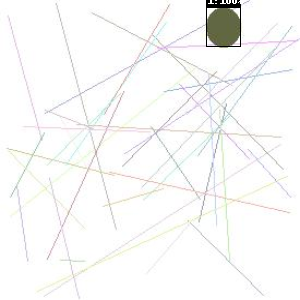

In [2]:
S = 10
B = 1
C = 1
IMG_SIZE = 300
model = YOLO(S, C, B, IMG_SIZE)
df = pd.read_csv('annotations.csv')
imgs_list = df['img_path'].unique()
dataset = yolo_dataset(S, B, C, IMG_SIZE, imgs_list)
dataloader = DataLoader(dataset, batch_size=1, shuffle=4)
img_tensor, target_tensor = next(iter(dataloader))

def desenhar_anotacoes(img_pil: Image, predictions_tensor, S, prob_threshold = 0.5, print_grid=False):

    assert predictions_tensor.shape == torch.rand((S, S, 5)).shape, "Tensor com shape inválido"

    predictions_tensor = predictions_tensor.detach().cpu().numpy()

    imgw, imgh = img_pil.size
    cell_size = 1 / S # tamanho de cada célula em percentual
    draw = ImageDraw.Draw(img_pil)

    if (print_grid):
        for k in range(S):
            draw.line([k*cell_size*imgw, 0, k*cell_size*imgw, imgh], fill='red', width=1)
            draw.line([0, k*cell_size*imgh, imgw, k*cell_size*imgh], fill='red', width=1)
    
    contador = 0
    bboxes = []
    for l in range(S):
        for c in range(S):
            prob = predictions_tensor[l, c, 0] # probabilidade de existir um objeto
            if (prob >= prob_threshold):
                contador += 1
                xc_rel, yc_rel, w_rel, h_rel = predictions_tensor[l,c,1:]*cell_size
                x1_cell, y1_cell = c*cell_size, l*cell_size
                xc, yc = x1_cell + xc_rel, y1_cell + yc_rel         ##
                w, h = w_rel, h_rel             #### Valores ainda em percentuais
                x1, y1, x2, y2 = xc-w/2, yc-h/2, xc+w/2, yc+h/2     ##

                x1, y1, x2, y2 = x1*imgw, y1*imgh, x2*imgw, y2*imgh
                bboxes.append([prob, x1, y1, x2, y2])

                draw.rectangle([x1, y1, x2, y2], fill=None, width=1, outline='black')
                draw.rectangle([x1, y1-15, x2, y1], fill='black')
                draw.text([x1+2, y1-13], f'{contador}:{round(100*prob)}%', fill='white')

    return img_pil, bboxes

img_pil = dataset.inv_transformer(img_tensor[0])
img_pil, bboxes = desenhar_anotacoes(img_pil, target_tensor[0], S)
img_pil